In [1]:
import matplotlib
%matplotlib inline
from pylab import *
import caesar
import h5py, os, sys
import yt, pickle, glob
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic as bst
from scipy.stats import binned_statistic_2d as bst2
from scipy.signal import savgol_filter as sgf

matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['ytick.labelsize'] = 18

safecolor={
    'silver':"#c0c0c0",
    'gray':"#808080",
    'black':"#000000",
    'red':"#ff0000",
    'maroon':"#800000",
    'yellow':"#ffff00",
    'olive':"#707030",
    'lime':"#00ee00",
    'green':"#009000",
    'aqua':"#00eeee",
    'teal':"#00a0a0",
    'blue':"#0000ff",
    'nave':"#000080",
    'fuchsia':"#ff00ff",
    'purple':"#900090"
}

In [23]:
from astropy.cosmology import Planck15

In [27]:
uage=(1/Planck15.H0).to('year').value

# Get radial data and dist to matched clusters from Caesar

In [2]:
# GIZMO Get M* satellite from Caesar
if os.path.isfile('data/GZS-galaxies-info-caesar.npy'):
    GZCshr=np.load('data/GZS-galaxies-info-caesar_nodust.npy')  #region[0], mass[1], central[2], u,g,r,i[3-6], metal[7], age mass-weighted[8], SFR[9], SFR_100[10] distance to matched center[11]
    GIZMO=np.loadtxt("GIZMO-Mass_snap_128-center-cluster.txt") #RIDs HIDs HostID Mvir[3] Xc Yc Zc[4-6] Rvir[7] fhires[8] cNFW[9] Mg200[10] M*200[11] M500[12] R500[13] fg500[14] f*500[15] 
    GMatch=np.loadtxt('GIZMO-Matched-AHFhalo-Caesar-galaxy.txt')
else:
    print('Can not find data!')

# cal quench fraction with sSFR<1e-11

In [4]:
fq2=np.zeros(324) #mass range 9-10
for i in range(324):
    ids=(GZCshr[:,0]==i+1)&(GZCshr[:,1]<1.0e10)&(GZCshr[:,1]>1.0e9)
    idq=(GZCshr[:,0]==i+1)&(GZCshr[:,1]<1.0e10)&(GZCshr[:,1]>1.0e9)&(GZCshr[:,9]/GZCshr[:,1]<1.0e-11)
    fq2[i]=len(GZCshr[idq,0])/len(GZCshr[ids,0])

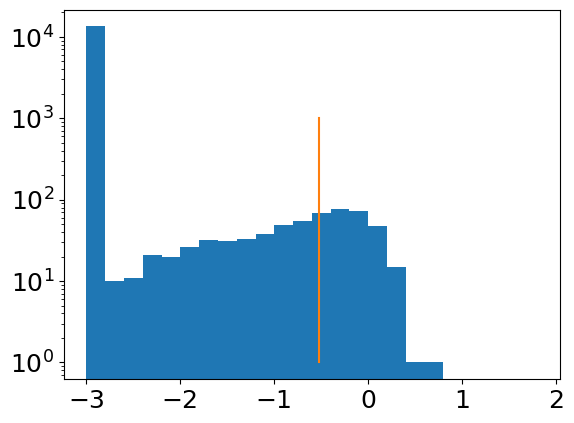

In [31]:
ids=np.copy(GZCshr[GZCshr[:,1]>10**10.5,9]/GZCshr[GZCshr[:,1]>10**10.5,1]*uage)
ids[ids<=1e-3]=1e-3
# ids2=np.copy(GZCshr[GZCshr[:,1]>10**10.5,10])
# ids2[ids2<=1e-2]=1e-2
hist(np.log10(ids),bins=np.arange(-3,2,0.2))
# hist(np.log10(ids2),bins=np.arange(-2,2,0.2))
plot([np.log10(0.3),np.log10(0.3)],[1,1e3])
yscale('log')

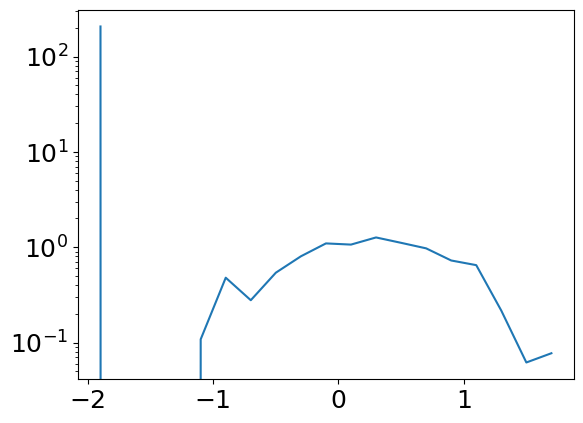

In [21]:
ids=np.copy(GZCshr[GZCshr[:,1]>10**10.5,9])
ids[ids<=1e-2]=1e-2
n,be=np.histogram(np.log10(ids),bins=np.arange(-2,2,0.2))
plot((be[1:]+be[:-1])/2, n/0.2/324)
yscale('log')

In [4]:
fq=np.zeros(324)
for i in range(324):
    ids=(GZCshr[:,0]==i+1)&(GZCshr[:,1]>1.0e10)
    idq=(GZCshr[:,0]==i+1)&(GZCshr[:,1]>1.0e10)&(GZCshr[:,9]/GZCshr[:,1]<1.0e-11)
    fq[i]=len(GZCshr[idq,0])/len(GZCshr[ids,0])

In [5]:
fq

array([0.9939759 , 1.        , 0.99209486, 0.99141631, 0.98076923,
       0.9924812 , 0.99553571, 0.99502488, 0.98734177, 0.995     ,
       0.98342541, 1.        , 0.99441341, 0.98857143, 1.        ,
       0.96682464, 0.99415205, 1.        , 1.        , 1.        ,
       0.99375   , 0.98245614, 1.        , 0.98895028, 0.99259259,
       0.97633136, 0.97326203, 0.99390244, 0.99431818, 1.        ,
       0.99346405, 0.99438202, 0.98245614, 0.98907104, 0.9875    ,
       0.99415205, 0.99328859, 0.98666667, 0.99411765, 0.984375  ,
       0.98787879, 0.98136646, 0.97222222, 0.99450549, 0.98      ,
       0.98148148, 1.        , 0.98561151, 0.98461538, 0.97810219,
       0.99230769, 0.99378882, 0.98275862, 0.97058824, 0.98039216,
       0.97674419, 0.98064516, 0.99275362, 0.99280576, 0.99411765,
       0.96932515, 0.9869281 , 1.        , 0.97037037, 0.98198198,
       0.98449612, 0.98780488, 1.        , 0.9921875 , 1.        ,
       0.98726115, 0.99337748, 0.98837209, 1.        , 1.     

# using g-r < 0.75 for blue galaxies to check the radial dependence

In [4]:
bins1=np.linspace(0.05, 1, num=8, endpoint=True)
bins2=np.logspace(np.log10(0.05), 0, num=8, endpoint=True)
bins1,bins2

(array([0.05      , 0.18571429, 0.32142857, 0.45714286, 0.59285714,
        0.72857143, 0.86428571, 1.        ]),
 array([0.05      , 0.07670637, 0.11767734, 0.18053204, 0.27695915,
        0.42489062, 0.65183634, 1.        ]))

In [12]:
GZCshr[:,-1]

array([   4.8469 ,  438.80865, 2091.3232 , ..., 1038.4218 , 1082.772  ,
        430.5349 ], dtype=float32)

In [5]:
rad_fq1=np.zeros((324,7),dtype=np.float32)+1 #linear bins
rad_fq2=np.zeros((324,7),dtype=np.float32)+1 #log bins
for i in range(324):
    ids=(GZCshr[:,0]==i+1)&(GZCshr[:,1]>1.0e10)
    rad=GZCshr[ids,11]/GIZMO[i,7] # /r200
    grc=GZCshr[ids,4]- GZCshr[ids,5]
    Nt1,b1=np.histogram(rad,bins=bins1)
    Nt2,b2=np.histogram(rad,bins=bins2)
    
    Nq1,b1=np.histogram(rad[grc>0.75],bins=bins1)
    Nq2,b2=np.histogram(rad[grc>0.75],bins=bins2)
    
    rad_fq1[i]=Nq1/Nt1
    idg0=Nt2>0
    rad_fq2[i][idg0]=Nq2[idg0]/Nt2[idg0]

In [18]:
rad_fqm1=np.zeros((324,7),dtype=np.float32)+1 #linear bins
rad_fqm2=np.zeros((324,7),dtype=np.float32)+1 #log bins
for i in range(324):
    ids=(GZCshr[:,0]==i+1)&(GZCshr[:,1]>1.0e10)
    rad=GZCshr[ids,11]/GIZMO[i,7] # /r200
    grc=GZCshr[ids,4]- GZCshr[ids,5]
    Nt1,b1=np.histogram(rad,bins=bins1)
    Nt2,b2=np.histogram(rad,bins=bins2)
    
    Nq1,b1=np.histogram(rad[grc>0.7],bins=bins1)
    Nq2,b2=np.histogram(rad[grc>0.7],bins=bins2)
    
    idg0=Nt1>0
    rad_fqm1[i][idg0]=Nq1[idg0]/Nt1[idg0]
    idg0=Nt2>0
    rad_fqm2[i][idg0]=Nq2[idg0]/Nt2[idg0]

In [22]:
# include semi galaxies
Galc=np.load("../optical/Galc_Satellite.npy") #ID(1) hostHalo(2) Region ID(3) Mvir(4) M_star(5) mag  'g','i','r','u','z' dist in r200
Sag =np.load("../optical/Sag_Satellite.npy")

rad_fgalc=np.zeros((324,7),dtype=np.float32)+1 #linear bins
rad_fsag=np.zeros((324,7),dtype=np.float32)+1
for i in range(324):
    ids=(Galc[:,2]==i+1)&(Galc[:,4]>1.0e10)
    rad= Galc[ids,10]# /r200
    grc=Galc[ids,5]- Galc[ids,7]
    Nt1,b1=np.histogram(rad,bins=bins1)    
    Nq1,b1=np.histogram(rad[grc>0.75],bins=bins1)
    idg0=Nt1>0
    rad_fgalc[i][idg0]=Nq1[idg0]/Nt1[idg0]

    ids=(Sag[:,2]==i+1)&(Sag[:,4]>1.0e10)
    rad= Sag[ids,10]# /r200
    grc=Sag[ids,5]- Sag[ids,7]
    Nt1,b1=np.histogram(rad,bins=bins1)    
    Nq1,b1=np.histogram(rad[grc>0.75],bins=bins1)
    idg0=Nt1>0
    rad_fsag[i][idg0]=Nq1[idg0]/Nt1[idg0]
    

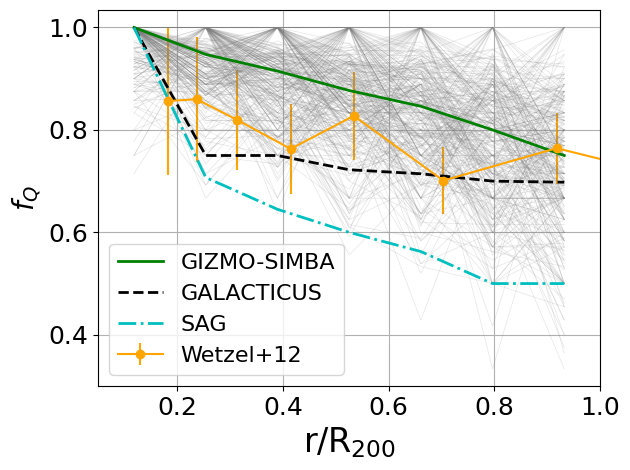

In [25]:
x=(bins1[1:]+bins1[:-1])/2
for i in range(324):
    plot(x,rad_fq1[i],lw=0.5,color='0.5',alpha=0.2)
plot(x,np.median(rad_fq1,axis=0), c='g',lw=2,label='GIZMO-SIMBA')
plot(x,np.median(rad_fgalc,axis=0),'k--', lw=2, label='GALACTICUS')
plot(x,np.median(rad_fsag,axis=0),'c-.', lw=2, label='SAG')
# plot(x,np.median(rad_fqm1,axis=0),label='M*>1e11')
xlabel('r/R$_{200}$',fontsize=24)
ylabel('$f_Q$',fontsize=20)

#Obsev data
errorbar(Wetzel12[:,0]/0.64,Wetzel12[:,1],yerr=Wetzel12[:,1]-Wetzel12[:,2], color='orange', marker='o',markersize=6,label='Wetzel+12')

grid()
legend(fontsize=16)
xlim(0.05,1)
tight_layout()
savefig('plots/fq_radial.pdf',dpi=300)

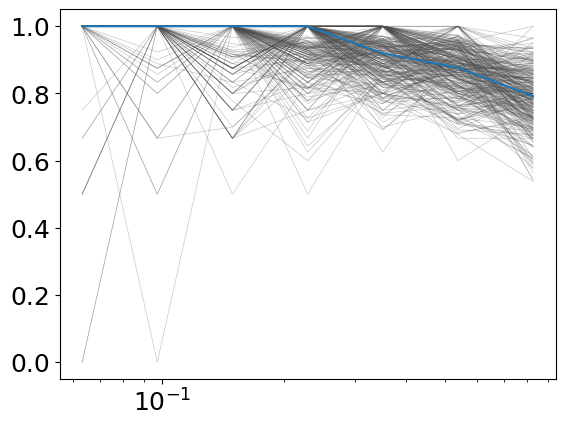

In [33]:
x=(bins2[1:]+bins2[:-1])/2
for i in range(324):
    plot(x,rad_fq2[i],lw=0.5,color='0.3',alpha=0.3)
plot(x,np.median(rad_fq2,axis=0))
xscale('log')

In [8]:
# Observ data
Wetzel12=np.array(
[
[0.11634474860813464, 0.8563573883161515, 0.7120274914089348],
[0.15133820466210873, 0.85979381443299, 0.7381443298969074],
[0.20063464177378523, 0.8192439862542957, 0.7223367697594503],
[0.26514737930417503, 0.7628865979381445,0.6756013745704467],
[0.3416342119815736, 0.8274914089347081, 0.7415807560137457],
[0.45005630290256826, 0.7010309278350517,0.6357388316151203],
[0.587279127023164, 0.7642611683848799, 0.6948453608247424],
[0.7615009199574675, 0.6948453608247424, 0.6329896907216495]
]
)
Wetzel12.shape

(8, 3)